In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
%matplotlib inline

# Task 1

We start with loading the data and providing initial insights.

In [9]:
df = pd.read_excel("http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.xls")

In [10]:
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
pclass       1309 non-null int64
survived     1309 non-null int64
name         1309 non-null object
sex          1309 non-null object
age          1046 non-null float64
sibsp        1309 non-null int64
parch        1309 non-null int64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null object
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 143.2+ KB


The first thing we will do, is to drop unnecessary columns and produce dummy variables for categorical features.

In [12]:
df = df[["survived", "pclass", "sex", "age", "sibsp", "parch", "fare", "embarked"]]

In [13]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,1,1,female,29.0000,0,0,211.3375,S
1,1,1,male,0.9167,1,2,151.5500,S
2,0,1,female,2.0000,1,2,151.5500,S
3,0,1,male,30.0000,1,2,151.5500,S
4,0,1,female,25.0000,1,2,151.5500,S


In [14]:
df.to_csv("data.csv")

This is the provided file of the assignment.

Let us check how the outcome (survived) is distributed.

In [15]:
np.average(df.survived)

0.3819709702062643

So around 38% of the passengers survived. The prediction problem is thus not completely unbalanced.

Now we sequentially go through the features, preprocess them properly, and check their statistics.

### Pclass

In [16]:
df.pclass.unique()

array([1, 2, 3])

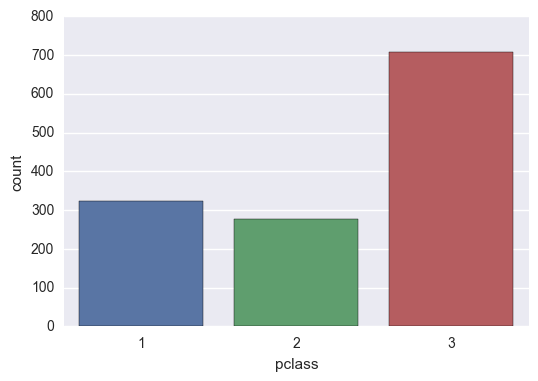

In [17]:
sns.countplot(x="pclass", data=df)

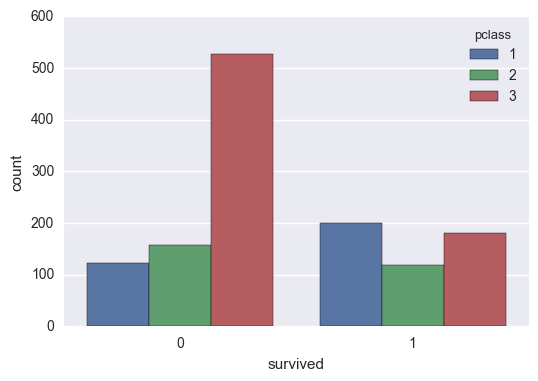

In [18]:
sns.countplot(x="survived", data=df, hue="pclass");

We can see that if you are first class, it seems likelier that you survived. Most of the passengers were in third class, where the probability to survive is much lower compared to dying.

In [19]:
dummies = pd.get_dummies(df["pclass"], prefix="pclass")
df = df.join(dummies)
del df["pclass"]

### Sex

In [20]:
df.sex.unique()

array(['female', 'male'], dtype=object)

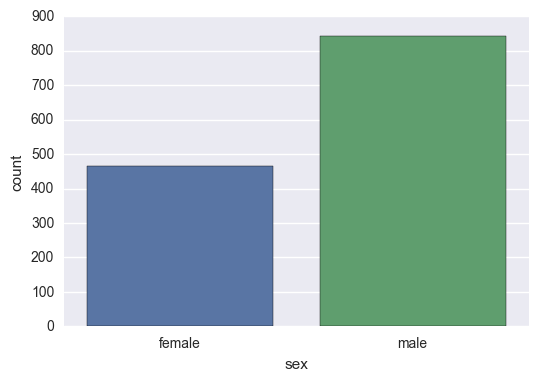

In [21]:
sns.countplot(x="sex", data=df)

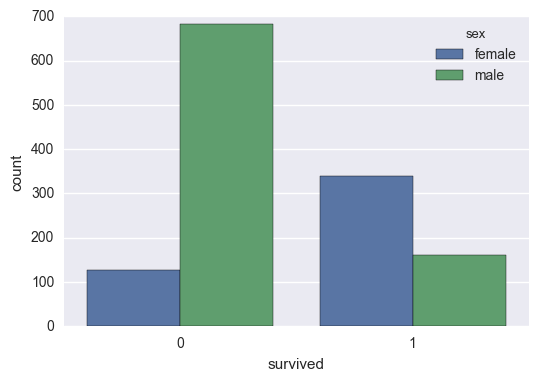

In [22]:
sns.countplot(x="survived", data=df, hue="sex");

While there were more males, females were likelier to survive.

In [23]:
dummies = pd.get_dummies(df["sex"], prefix="sex")
df = df.join(dummies)
del df["sex"]
del df["sex_female"]

### Age

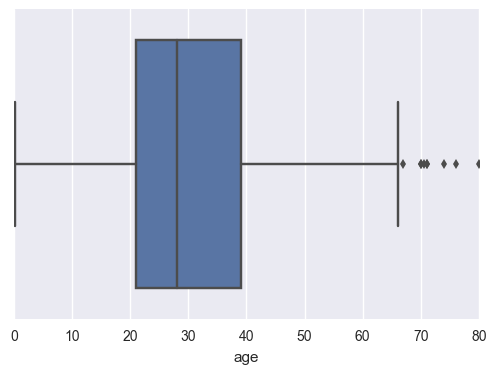

In [24]:
sns.boxplot(df.age)

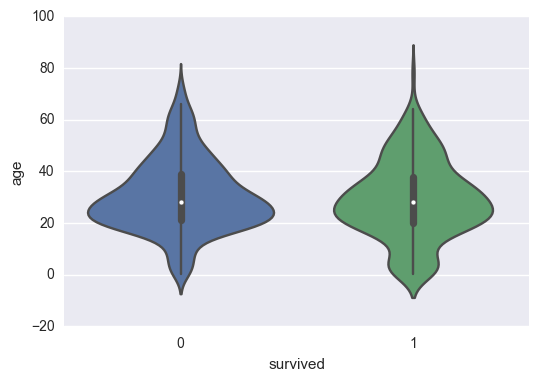

In [25]:
sns.violinplot(x="survived", y="age", data=df);

Intuitively, we cannot see clear trends here only slightly higher shares of young ages for survivors.

### Sibsp

In [26]:
df.sibsp.unique()

array([0, 1, 2, 3, 4, 5, 8])

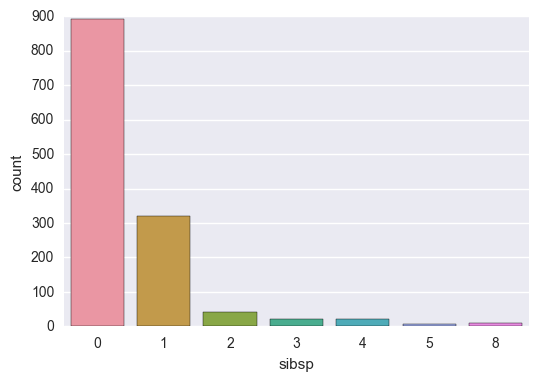

In [27]:
sns.countplot(df.sibsp)

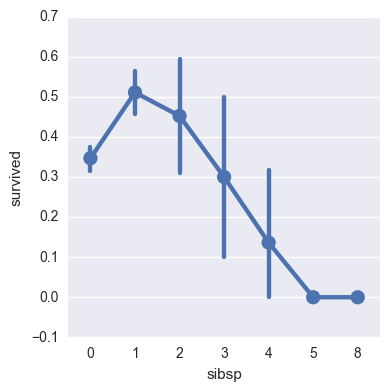

In [28]:
sns.factorplot(x="sibsp", y="survived", data=df)

It appears that you have the best chances if you have only one sibling/spouse.

### Parch

In [29]:
df.parch.unique()

array([0, 2, 1, 4, 3, 5, 6, 9])

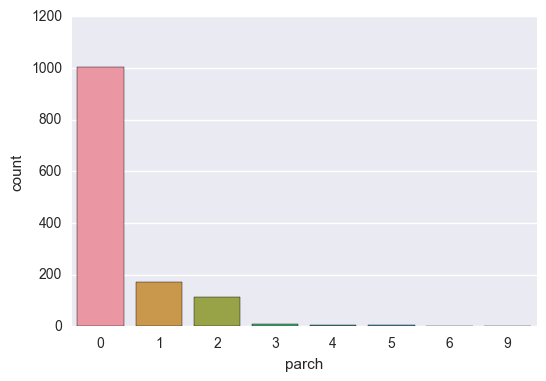

In [30]:
sns.countplot(df.parch)

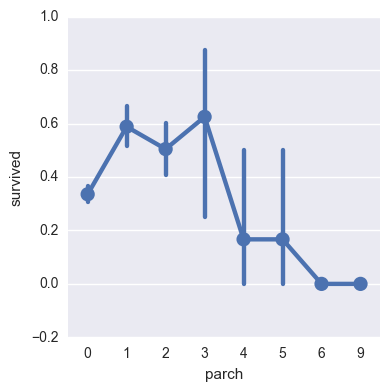

In [31]:
sns.factorplot(x="parch", y="survived", data=df)

Families of medium size appear to have the best chances.

We could build combined features of parch and sibsp to present a feature for the whole family. But we expect the decision tree to find rules that are more fine-grained, also in a combinatory fashion.

### Fare

/home/psinger/anaconda2/envs/python3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


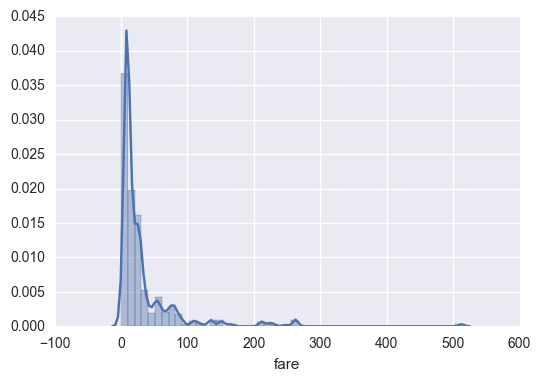

In [32]:
sns.distplot(df.fare.dropna())

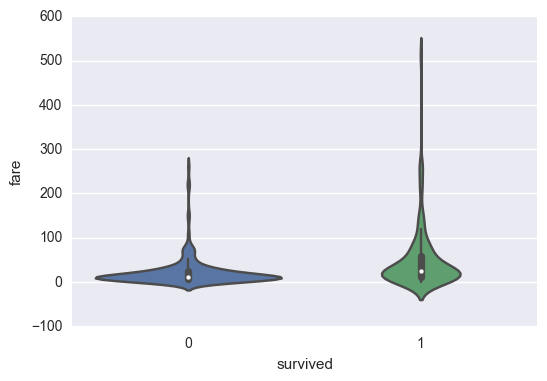

In [33]:
sns.violinplot(x="survived", y="fare", data=df)

Non-survivors appear to have paid a smaller fare. This is mostly also due to the correlation of fare with class.

In [34]:
df[["fare", "pclass_1", "pclass_2", "pclass_3"]].corr()

,fare,pclass_1,pclass_2,pclass_3
fare,1.000000,0.600031,-0.121384,-0.419752
pclass_1,0.600031,1.000000,-0.296526,-0.622172
pclass_2,-0.121384,-0.296526,1.000000,-0.563180
pclass_3,-0.419752,-0.622172,-0.563180,1.000000


So the higher the fare, the more likely someone is in class 1.

### Embarked

In [35]:
df.embarked.unique()

array(['S', 'C', nan, 'Q'], dtype=object)

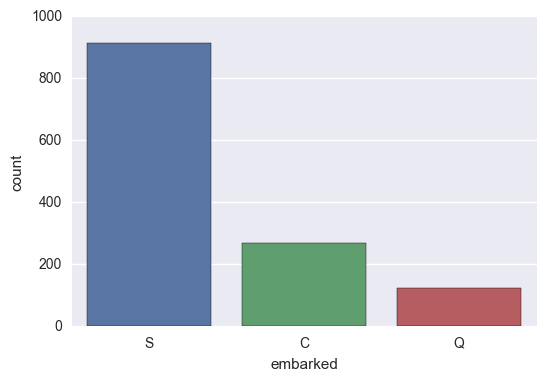

In [36]:
sns.countplot(df.embarked)

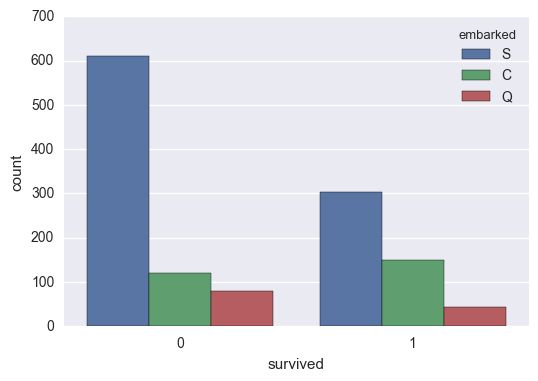

In [37]:
sns.countplot(x="survived", data=df, hue="embarked");

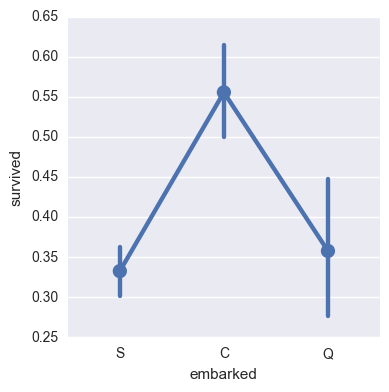

In [38]:
sns.factorplot(x="embarked", y="survived", data=df)

If you have been embarked in Cherbourgh, you had the highest chances of surviving.

In [39]:
dummies = pd.get_dummies(df["embarked"], prefix="embarked")
df = df.join(dummies)
del df["embarked"]

In [40]:
df.head()

,survived,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,sex_male,embarked_C,embarked_Q,embarked_S
0,1,29.0000,0,0,211.3375,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,0.9167,1,2,151.5500,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0,2.0000,1,2,151.5500,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,30.0000,1,2,151.5500,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0,25.0000,1,2,151.5500,1.0,0.0,0.0,0.0,0.0,0.0,1.0


We can directly get a statistical overview over all columns by calling ``describe()``.

In [41]:
df.describe()

/home/psinger/anaconda2/envs/python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,survived,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,sex_male,embarked_C,embarked_Q,embarked_S
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,0.381971,29.881135,0.498854,0.385027,33.295479,0.246753,0.211612,0.541635,0.644003,0.206264,0.093965,0.698243
std,0.486055,14.413500,1.041658,0.865560,51.758668,0.431287,0.408607,0.498454,0.478997,0.404777,0.291891,0.459196
min,0.000000,0.166700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,NaN,1.000000,0.000000,NaN,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,80.000000,8.000000,9.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Let us also correlate the features.

In [42]:
df.corr()

,survived,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,sex_male,embarked_C,embarked_Q,embarked_S
survived,1.000000,-0.055513,-0.027825,0.082660,0.244265,0.279449,0.050790,-0.283428,-0.528693,0.182123,-0.016071,-0.154558
age,-0.055513,1.000000,-0.243699,-0.150917,0.178739,0.393198,-0.014986,-0.337069,0.063646,0.085777,-0.019458,-0.075971
sibsp,-0.027825,-0.243699,1.000000,0.373587,0.160238,-0.034256,-0.052419,0.072610,-0.109609,-0.048396,-0.048678,0.075198
parch,0.082660,-0.150917,0.373587,1.000000,0.221539,-0.013033,-0.010057,0.019521,-0.213125,-0.008635,-0.100943,0.073258
fare,0.244265,0.178739,0.160238,0.221539,1.000000,0.600031,-0.121384,-0.419752,-0.185523,0.286269,-0.130059,-0.172683
pclass_1,0.279449,0.393198,-0.034256,-0.013033,0.600031,1.000000,-0.296526,-0.622172,-0.107371,0.325722,-0.166101,-0.187353
pclass_2,0.050790,-0.014986,-0.052419,-0.010057,-0.121384,-0.296526,1.000000,-0.563180,-0.028862,-0.134675,-0.121973,0.197973
pclass_3,-0.283428,-0.337069,0.072610,0.019521,-0.419752,-0.622172,-0.563180,1.000000,0.116562,-0.171430,0.243706,-0.000181
sex_male,-0.528693,0.063646,-0.109609,-0.213125,-0.185523,-0.107371,-0.028862,0.116562,1.000000,-0.066564,-0.088651,0.119504
embarked_C,0.182123,0.085777,-0.048396,-0.008635,0.286269,0.325722,-0.134675,-0.171430,-0.066564,1.000000,-0.164166,-0.775441


The correlations for the first row of survived with the features also gives us an indicator of how the features contribute to survival. For example, pclass_1 has a clearly positive correlation, meaning that it is more likely to survive if you are in first class.

# Task 2

Now, we focus on classification using scikit-learn's Decision Tree algorithm.

In [43]:
from sklearn.tree import DecisionTreeClassifier

In [44]:
df.head()

,survived,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,sex_male,embarked_C,embarked_Q,embarked_S
0,1,29.0000,0,0,211.3375,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,0.9167,1,2,151.5500,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0,2.0000,1,2,151.5500,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,30.0000,1,2,151.5500,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0,25.0000,1,2,151.5500,1.0,0.0,0.0,0.0,0.0,0.0,1.0


We start with the analysis of feature decisions by fitting on the complete data.

In [45]:
Y = df.survived
X = df.ix[:, df.columns != 'survived']

We need to handle missing values.

In [46]:
from sklearn.preprocessing import Imputer
imputer = Imputer()
X = imputer.fit_transform(X)

In [47]:
X

array([[ 29.    ,   0.    ,   0.    , ...,   0.    ,   0.    ,   1.    ],
       [  0.9167,   1.    ,   2.    , ...,   0.    ,   0.    ,   1.    ],
       [  2.    ,   1.    ,   2.    , ...,   0.    ,   0.    ,   1.    ],
       ..., 
       [ 26.5   ,   0.    ,   0.    , ...,   1.    ,   0.    ,   0.    ],
       [ 27.    ,   0.    ,   0.    , ...,   1.    ,   0.    ,   0.    ],
       [ 29.    ,   0.    ,   0.    , ...,   0.    ,   0.    ,   1.    ]])

In [48]:
clf = DecisionTreeClassifier()
clf = clf.fit(X, Y)

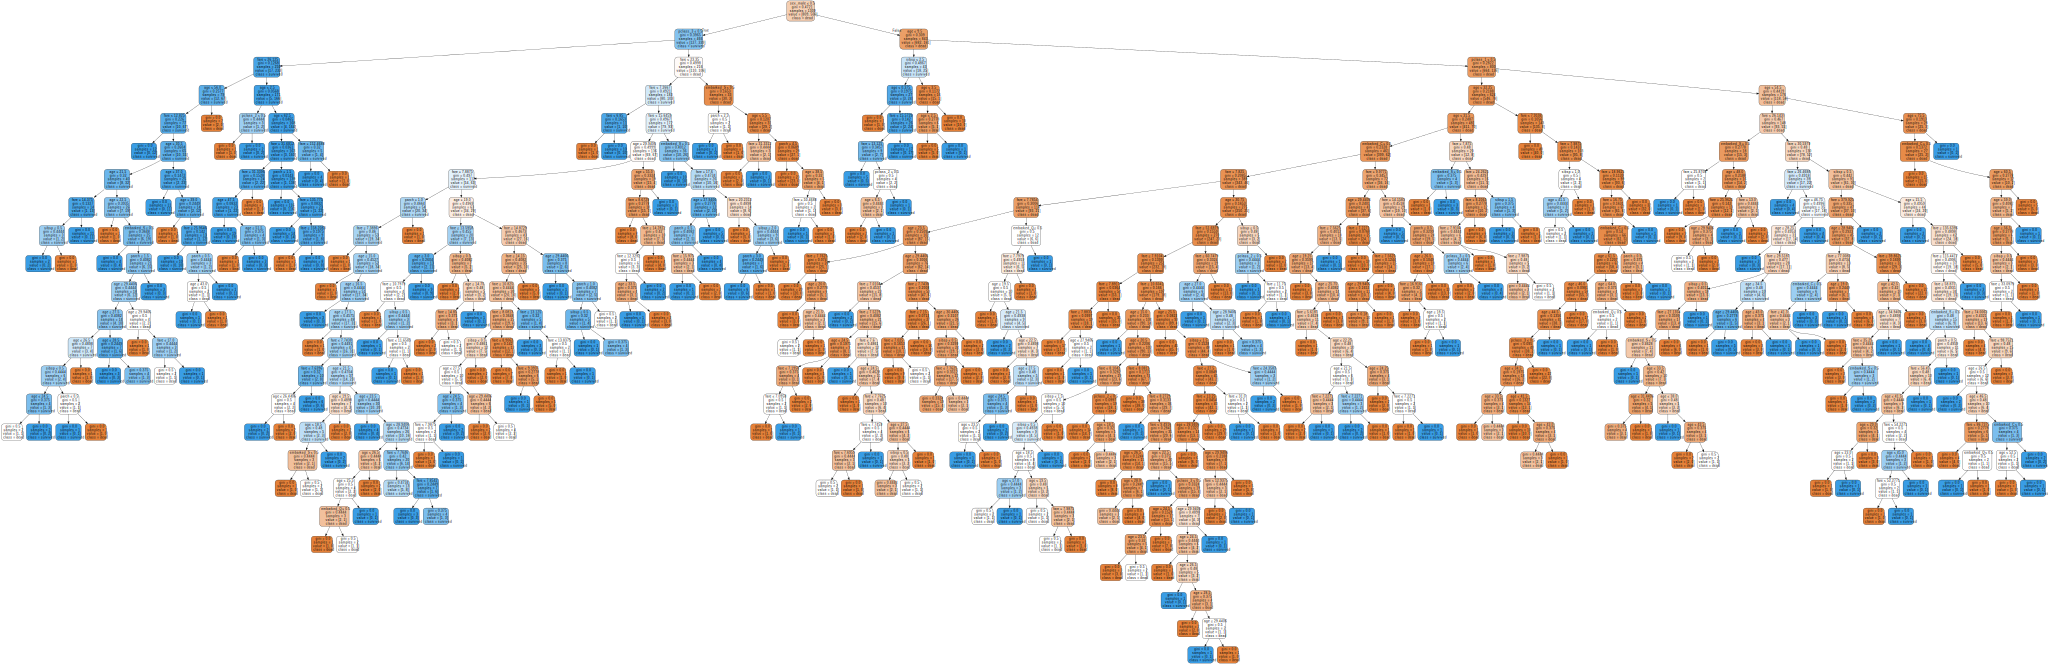

In [49]:
import pydotplus 
from sklearn.tree import export_graphviz
from IPython.display import SVG, display

dot_data = export_graphviz(clf, out_file='tree.dot',
                           feature_names=df.ix[:, df.columns != 'survived'].columns.values,
                          class_names=["dead", "survived"], filled=True, rounded=True,  
                         special_characters=True) 
graph = pydotplus.graph_from_dot_file('tree.dot') 
display(SVG(graph.create_svg()))


In [50]:
importance = clf.feature_importances_

In [51]:
print(zip(df.ix[:, df.columns != 'survived'].columns.values,importance))

Sex is the most important features, followed by fare and age. Interestingly, the embarked features do not appear to play that much of a role.

Now, let's check predictive power.

In [52]:
from sklearn.cross_validation import train_test_split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [98]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7531806615776081

Let's check random forests.

In [55]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.75826972010178118

Now, let's do proper cross validation.

In [56]:
from sklearn.cross_validation import cross_val_score

In [57]:
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X, Y, cv=10)
print(scores)
print(scores.mean())

[ 0.67175573  0.77862595  0.83206107  0.70992366  0.76335878  0.74045802
  0.64122137  0.61068702  0.67938931  0.7       ]
0.712748091603


How does this compare to a simple baseline model?

In [58]:
Y.mean()

0.3819709702062643

In [59]:
y_baseline = len(y_test)*[0.0]

In [60]:
from sklearn.metrics import accuracy_score
accuracy_score(y_baseline, y_test)

0.62595419847328249

So while we can (partly) outperform the baseline, the classifier for sure can be improved.

In [61]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

In [62]:
pipeline = Pipeline([('clf',DecisionTreeClassifier())])

parameters = {
    'clf__max_depth': (10, 50, 100, 150, 200),
    'clf__min_samples_split': (1, 2, 3, 4, 5),
    'clf__min_samples_leaf': (1, 2, 3, 4, 5)
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1,verbose=1, scoring='accuracy')
grid_search.fit(X, Y)
print(grid_search.best_score_)

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))



Fitting 5 folds for each of 125 candidates, totalling 625 fits
0.687547746371
	clf__max_depth: 10
	clf__min_samples_leaf: 1
	clf__min_samples_split: 1


[Parallel(n_jobs=-1)]: Done 625 out of 625 | elapsed:    1.6s finished


Not much improvement. Some feature engineering would most likely improve the classification performance. Also, handling the missing data in different ways, might influence results. For some further strategies check: https://www.kaggle.com/omarelgabry/titanic/a-journey-through-titanic

We showcase the replacement of missing age values by predicting them from the remaining features.

In [63]:
df_copy = df.copy()

In [64]:
df_copy_age = df_copy[df_copy.age.isnull() == False]
df_copy_noage = df_copy[df_copy.age.isnull()]
X_train = df_copy_age.ix[:, df_copy_age.columns != 'age']
X_train = X_train.ix[:, X_train.columns != 'survived']
y_train = df_copy_age.age.values
X_test = df_copy_noage.ix[:, df_copy_noage.columns != 'age']
X_test = X_test.ix[:, X_test.columns != 'survived']
y_test = df_copy_noage.age.values

In [65]:
from sklearn.ensemble import GradientBoostingRegressor
imputer = Imputer()
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
clf = GradientBoostingRegressor()
clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [66]:
df_copy_noage.age = clf.predict(X_test)

/home/psinger/anaconda2/envs/python3/lib/python3.5/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [67]:
df_new = pd.concat([df_copy_age, df_copy_noage])

In [68]:
Y = df_new.survived
X = df_new.ix[:, df_new.columns != 'survived']

In [69]:
imputer = Imputer()
X = imputer.fit_transform(X)

In [70]:
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X, Y, cv=10)
print(scores)
print(scores.mean())

[ 0.54961832  0.80916031  0.80916031  0.76335878  0.72519084  0.66412214
  0.60305344  0.54961832  0.70992366  0.64615385]
0.682935995302


Not much changed.